####  2세대 도감 만들기 
<hr>
1. 251 마리의 이미지를 받아서 <br>
2. 70 * 70 사이즈로 리사이즈 <br>
3. 컬러로 돌릴 예정   약 4900*3 = 150000 컬럼 예상<br>
4. 이미지 251개를 10배가량 복제할 예정<br>
5. 이미지 처리후, csv에 저장. <br>
<hr>
6. csv로부터 파일을 읽어서 도감 번호를 타겟으로 설정 하여 트레인/테스트<br>
7. 모델 만들기.<br>
8. 여유있으면 웹연결하여 예측모델 만들기.<br>




In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv
from rembg import remove #배경 제거

In [ ]:
def resize_image(image, width=None, height=None, fx=None, fy=None, interpolation=cv2.INTER_LINEAR):
    """
    cv2.resize()를 활용하여 이미지를 크기 조정하는 함수

    Parameters:
        image (numpy.ndarray): 원본 이미지
        width (int, optional): 새로운 이미지의 너비 (dsize와 함께 사용)
        height (int, optional): 새로운 이미지의 높이 (dsize와 함께 사용)
        fx (float, optional): 가로 크기 비율 (dsize 대신 사용 가능)
        fy (float, optional): 세로 크기 비율 (dsize 대신 사용 가능)
        interpolation (int, optional): 보간법 (기본값 cv2.INTER_LINEAR)

    Returns:
        numpy.ndarray: 크기 조정된 이미지
    """
    if width is not None and height is not None:
        dsize = (width, height)
    else:
        dsize = None  # fx, fy가 사용됨

    resized = cv2.resize(image, dsize=dsize, fx=fx, fy=fy, interpolation=interpolation)
    return resized

In [ ]:
def rotate_image(image, angle, center=None, scale=1.0):
    """
    이미지를 특정 각도로 회전하는 함수

    Parameters:
        image (numpy.ndarray): 원본 이미지
        angle (float): 회전 각도 (반시계 방향)
        center (tuple, optional): 회전 중심 좌표 (기본값: 이미지 중앙)
        scale (float, optional): 크기 비율 (기본값: 1.0)

    Returns:
        numpy.ndarray: 회전된 이미지
    """
    (h, w) = image.shape[:2]
    if center is None:
        center = (w // 2, h // 2)  # 중심점을 이미지 중앙으로 설정

    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [ ]:
def flip_image(image, flip_code):
    """
    이미지를 뒤집는 함수

    Parameters:
        image (numpy.ndarray): 원본 이미지
        flip_code (int): 0 (상하 뒤집기), 1 (좌우 뒤집기), -1 (상하+좌우 뒤집기)

    Returns:
        numpy.ndarray: 뒤집힌 이미지
    """
    flipped = cv2.flip(image, flip_code)
    return flipped

In [ ]:

def remove_background(image):
    """
    rembg를 이용하여 이미지의 배경을 제거하는 함수

    Parameters:
        image (numpy.ndarray): 원본 이미지 (BGR 형식)

    Returns:
        numpy.ndarray: 배경이 제거된 이미지 (RGBA 형식)
    """
    # OpenCV의 이미지를 PIL 이미지로 변환
    import PIL.Image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV 이미지는 BGR이므로 변환 필요
    pil_image = PIL.Image.fromarray(image_rgb)

    # 배경 제거 수행
    output_pil = remove(pil_image)

    # 다시 OpenCV 형식으로 변환 (RGBA 형식 유지)
    output = np.array(output_pil)

    output_bgr = cv2.cvtColor(output, cv2.COLOR_RGBA2BGR)
    return output_bgr

In [ ]:
data_dir = './_data/'
img_dir  = './_image/'

alimglist = os.listdir(img_dir)

In [ ]:
imglist= [x for x in alimglist if (x[-3:]=='png') and (x[5]=='1')]
print(len(imglist), imglist[150])

In [ ]:
def make_test(img_dir, name,poke_num):
    imglist = os.listdir(img_dir)
    resultDF = pd.DataFrame(columns=list(range(14701)))
    for i in imglist[:10]:
        print(i)
        a = cv2.imread(img_dir+i, cv2.IMREAD_COLOR)
        # a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        print(a.shape, 'a')
        # b = remove_background(a)
        c = resize_image(a, 70, 70)
        print(c.shape, 'c')
        cv2.imwrite('./_image/test/tested/'+i,c)
        resultDF.loc[i,0] = poke_num
        resultDF.loc[i,1:] = c.flatten()
        resultDF.loc[:,1:] = resultDF.loc[:,1:].astype('float')/255
        resultDF.to_csv(data_dir+name)
    return resultDF

In [ ]:
tempDF = make_test('./_image/test/', 'test152.csv', 152)

In [ ]:
tempDF.shape

In [ ]:
tempDF.iloc[0,1:].values.reshape(70,70,3).astype('float32')

In [ ]:
tempDF.iloc[:,1:]=tempDF.iloc[:,1:]*255

In [ ]:
z = tempDF.iloc[0,1:].values.reshape(70,70,3)
plt.imshow(z.astype('float32'))
tempDF.iloc[0,1:].values.reshape(70,70,3)

test (1).jpg
(70, 70, 3) a
(70, 70, 3) c


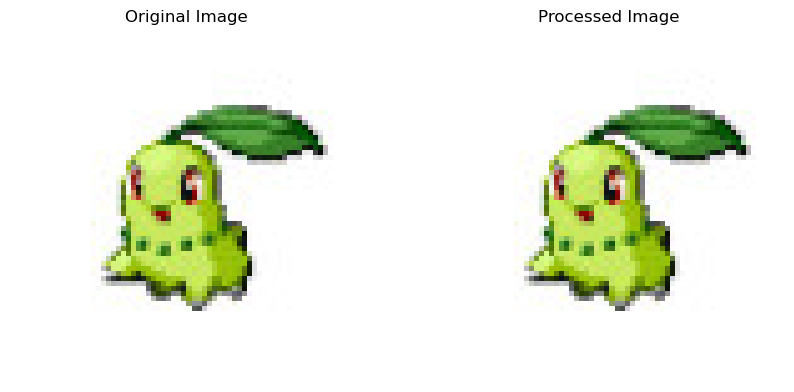

test (10).jpg
(70, 70, 3) a
(70, 70, 3) c


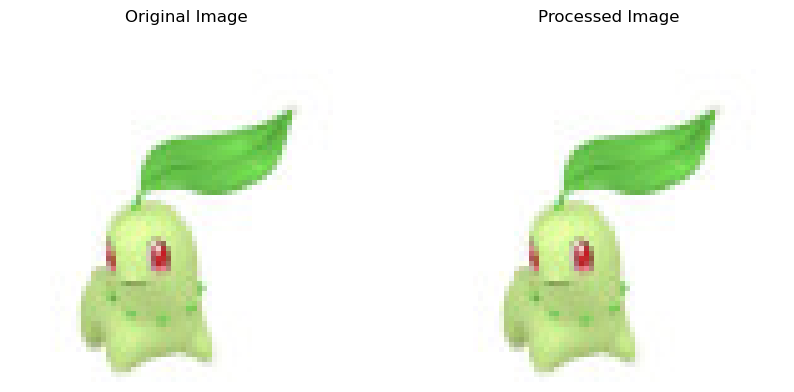

test (11).jpg
(70, 70, 3) a
(70, 70, 3) c


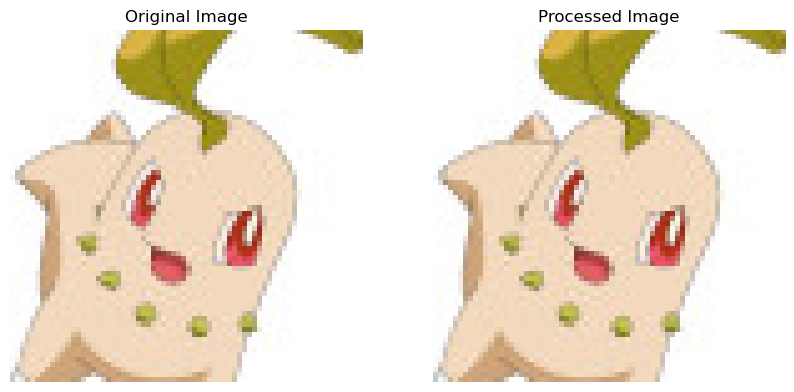

test (12).jpg
(70, 70, 3) a
(70, 70, 3) c


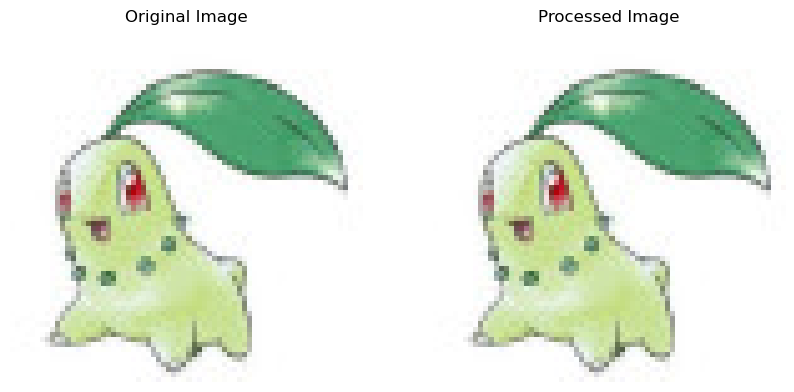

test (13).jpg
(70, 70, 3) a
(70, 70, 3) c


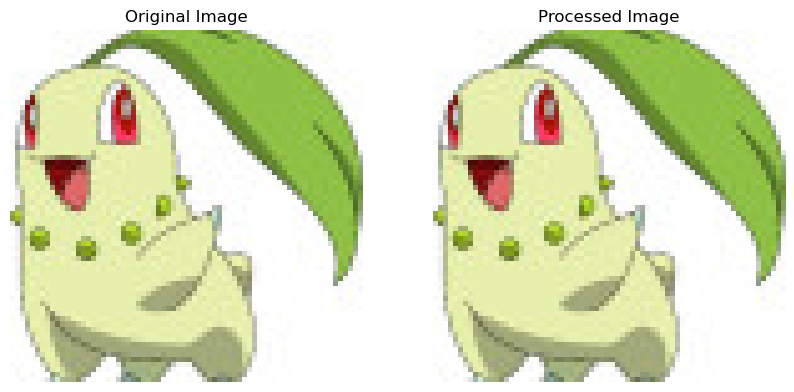

test (14).jpg
(70, 70, 3) a
(70, 70, 3) c


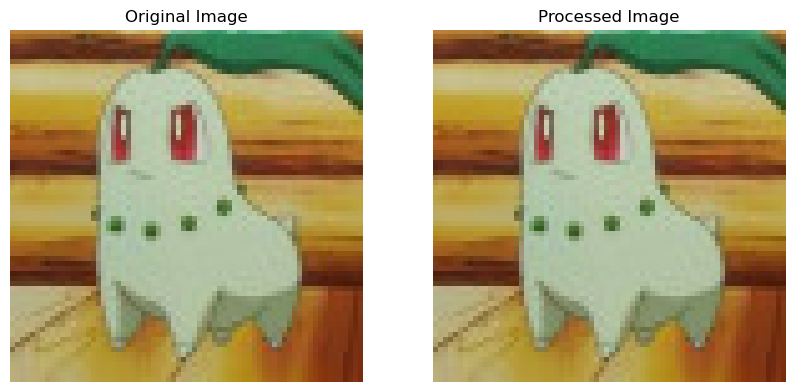

test (15).jpg
(70, 70, 3) a
(70, 70, 3) c


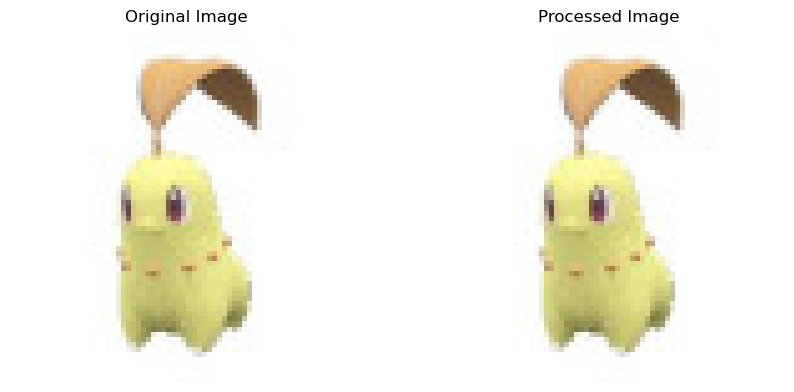

test (16).jpg
(70, 70, 3) a
(70, 70, 3) c


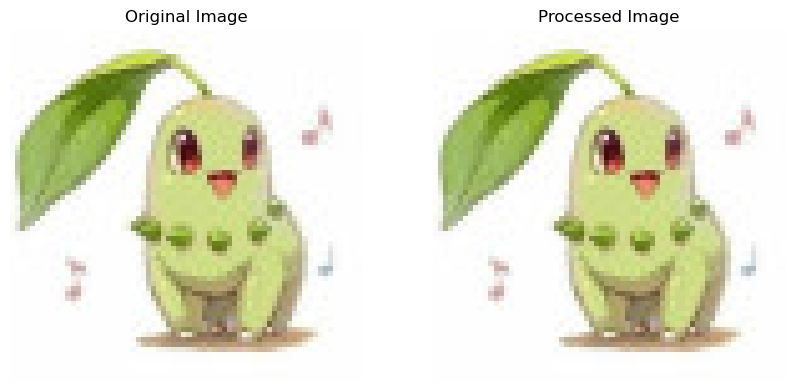

test (17).jpg
(70, 70, 3) a
(70, 70, 3) c


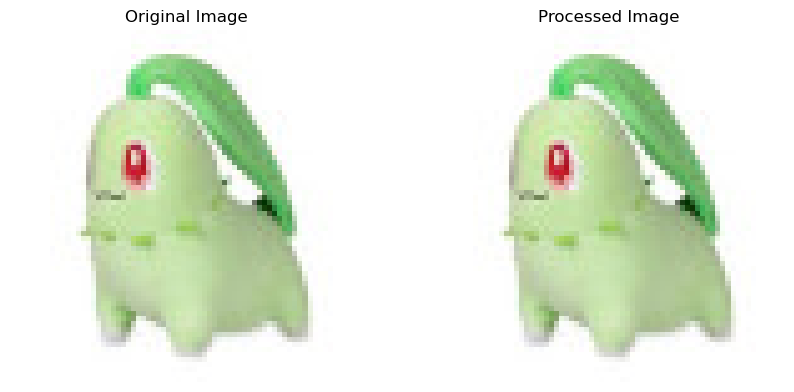

test (18).jpg
(70, 70, 3) a
(70, 70, 3) c


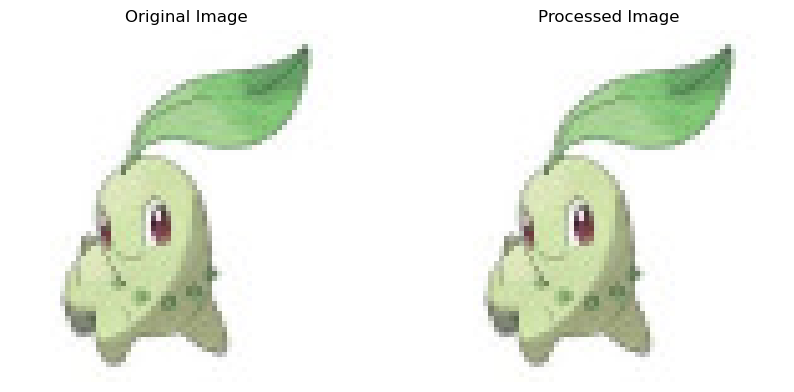

(10, 14701)


In [235]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

def make_test(img_dir, name, poke_num):
    imglist = os.listdir(img_dir)
    resultDF = pd.DataFrame(columns=list(range(14701)))  # 컬럼을 14701로 설정
    for i in imglist[:10]:  # 첫 10개의 이미지 처리
        print(i)
        a = cv2.imread(os.path.join(img_dir, i), cv2.IMREAD_COLOR)  # 경로를 올바르게 결합
        print(a.shape, 'a')
        
        # 이미지 크기 조정
        c = resize_image(a, 70, 70)
        print(c.shape, 'c')
        
        # 이미지 저장
        cv2.imwrite('./_image/test/tested/' + i, c)
        
        # 결과 DataFrame에 데이터 추가
        resultDF.loc[i, 0] = poke_num
        resultDF.loc[i, 1:] = c.flatten()
        
        # 데이터를 0과 1 사이로 정규화
        resultDF.loc[i, 1:] = resultDF.loc[i, 1:].astype('float') / 255
        
        # DataFrame을 CSV로 저장
        resultDF.to_csv(os.path.join(data_dir, name))  # data_dir을 경로로 사용
        
        # 원본 이미지와 처리된 이미지 출력
        original_rgb = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)  # OpenCV 이미지를 RGB로 변환
        processed_rgb = cv2.cvtColor(c, cv2.COLOR_BGR2RGB)  # 처리된 이미지도 RGB로 변환
        
        # 2개의 이미지를 나란히 출력
        plt.figure(figsize=(10, 5))  # 화면 크기 설정
        plt.subplot(1, 2, 1)  # 첫 번째 서브플롯
        plt.imshow(original_rgb)  # 원본 이미지 표시
        plt.title('Original Image')
        plt.axis('off')  # 축을 표시하지 않음

        plt.subplot(1, 2, 2)  # 두 번째 서브플롯
        plt.imshow(processed_rgb)  # 처리된 이미지 표시
        plt.title('Processed Image')
        plt.axis('off')  # 축을 표시하지 않음
        
        plt.show()  # 이미지 출력

    return resultDF

# 함수 호출 예시
tempDF = make_test('./_image/test/', 'test152.csv', 152)
print(tempDF.shape)


In [ ]:
resultDF = pd.DataFrame(columns=list(range(14701)))
for i in imglist[150:]:
    print(i)
    a = cv2.imread(img_dir+i, cv2.IMREAD_COLOR)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    # print(a.shape, 'a')
    # b = remove_background(a)
    # print(b.shape, 'b')
    c = resize_image(a, 70, 70)
    # print(c.shape, 'c')
    for j in range(0, 361, 30):
        d = rotate_image(c,j,(35,35))
        # print(d.shape)
        resultDF.loc[i[1:4]+str(j),0] = i[1:4]
        resultDF.loc[i[1:4]+str(j),1:] = d.flatten()
        e = flip_image(d,1)
        resultDF.loc[i[1:4]+str(j)+'i',0] = i[1:4]
        resultDF.loc[i[1:4]+str(j)+'i',1:] = e.flatten()

In [ ]:
resultDF.shape

In [ ]:
resultDF.tail()

In [ ]:
resultDF.loc[:,1:] = resultDF.loc[:,1:].astype('float')/255


In [ ]:
resultDF

In [ ]:
resultDF.to_csv(data_dir+'sd_poke')